# Credit Card Fraud Detection, Part 1: No Data-Balancing/Scaling of PCA Features


# Introduction

## Objective
Classify transactions as fraudulent or non-fraudulent using machine learning.

## Dataset
Source: Kaggle Credit Card Fraud Detection dataset

Number of transactions: 284,807

Fraudulent transactions: 492 (0.172% of all transactions)

Features: time, V1-V28 (PCA features), amount, class

## Action plan
Part 1:  
- Take care of EDA and the bulk of the data preprocessing
- Establish performance metrics for our problem
- Begin modeling with minimal tuning

Part 2:
- Apply universal scaling on all features (including the PCA-engineered features)
- Compare model performance and decide whether we should proceed with scaled or unscaled data
- Apply data balancing techniques and see if model performance improves
- Select best algorithms to move forward with
- Using the top performing algorithm and balancing/scaling technique combinations, tune them


# Initial Steps

In [ ]:
# Link to Kaggle and access the dataset
!mkdir ~/.kaggle
!cp "/content/drive/MyDrive/Portfolio projects/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
 89% 59.0M/66.0M [00:00<00:00, 125MB/s]
100% 66.0M/66.0M [00:00<00:00, 105MB/s]
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [ ]:
# Define the base file location for pathlib files
# This will help us continue the code in parts 2 and 3
base_path = '/content/drive/MyDrive/Portfolio projects/Credit Card Fraud Detection/joblib files/'

In [ ]:
# Import statements
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_recall_curve, auc, precision_score, recall_score, accuracy_score, fbeta_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
import time
from pathlib import Path

pd.set_option('display.max_columns', None)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Import dataset
df = pd.read_csv('creditcard.csv')
df.drop_duplicates(inplace=True)
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


# EDA + Preprocessing

In [ ]:
# Check all columns of dataset
df.info()
# All features are of type float64, target is binary (0 or 1 = int64)

<class 'pandas.core.frame.DataFrame'>
Index: 283726 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    283726 non-null  float64
 1   V1      283726 non-null  float64
 2   V2      283726 non-null  float64
 3   V3      283726 non-null  float64
 4   V4      283726 non-null  float64
 5   V5      283726 non-null  float64
 6   V6      283726 non-null  float64
 7   V7      283726 non-null  float64
 8   V8      283726 non-null  float64
 9   V9      283726 non-null  float64
 10  V10     283726 non-null  float64
 11  V11     283726 non-null  float64
 12  V12     283726 non-null  float64
 13  V13     283726 non-null  float64
 14  V14     283726 non-null  float64
 15  V15     283726 non-null  float64
 16  V16     283726 non-null  float64
 17  V17     283726 non-null  float64
 18  V18     283726 non-null  float64
 19  V19     283726 non-null  float64
 20  V20     283726 non-null  float64
 21  V21     283726 

In [ ]:
# Looking for any null values to handle
df.isna().sum()
# No null values

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


In [ ]:
# Counting each class occurence
df['Class'].value_counts()
# Very imbalanced dataset

,count
Class,
0,283253
1,473


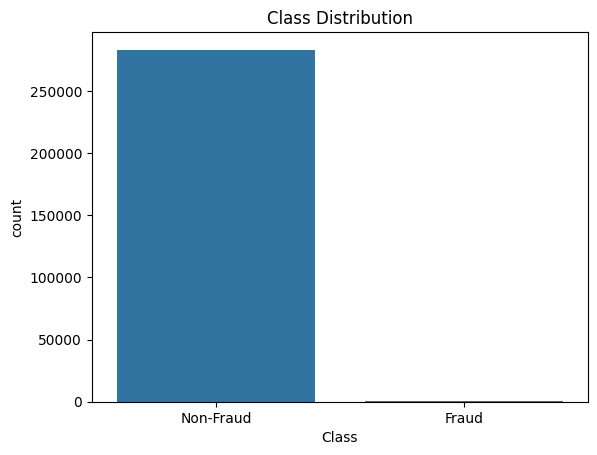

In [ ]:
# Visualize the difference between fraud and non-fraud instances
sns.countplot(x='Class', data=df)
plt.title('Class Distribution')
plt.xticks(ticks=[0, 1], labels=['Non-Fraud', 'Fraud'])
plt.show()
# Massive difference

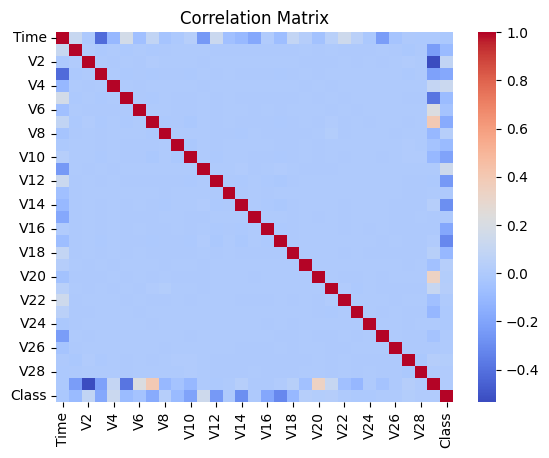

In [ ]:
# Visualize correlation between features, target
sns.heatmap(df.corr(), cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
# For the most part, features are pretty uncorrelated

In [ ]:
# Check the numeric correlation between features and class
df.corr()['Class'].sort_values(ascending=False)

,Class
Class,1.000000
V11,0.149067
V4,0.129326
V2,0.084624
V19,0.033631
V8,0.033068
V21,0.026357
V27,0.021892
V20,0.021486
V28,0.009682


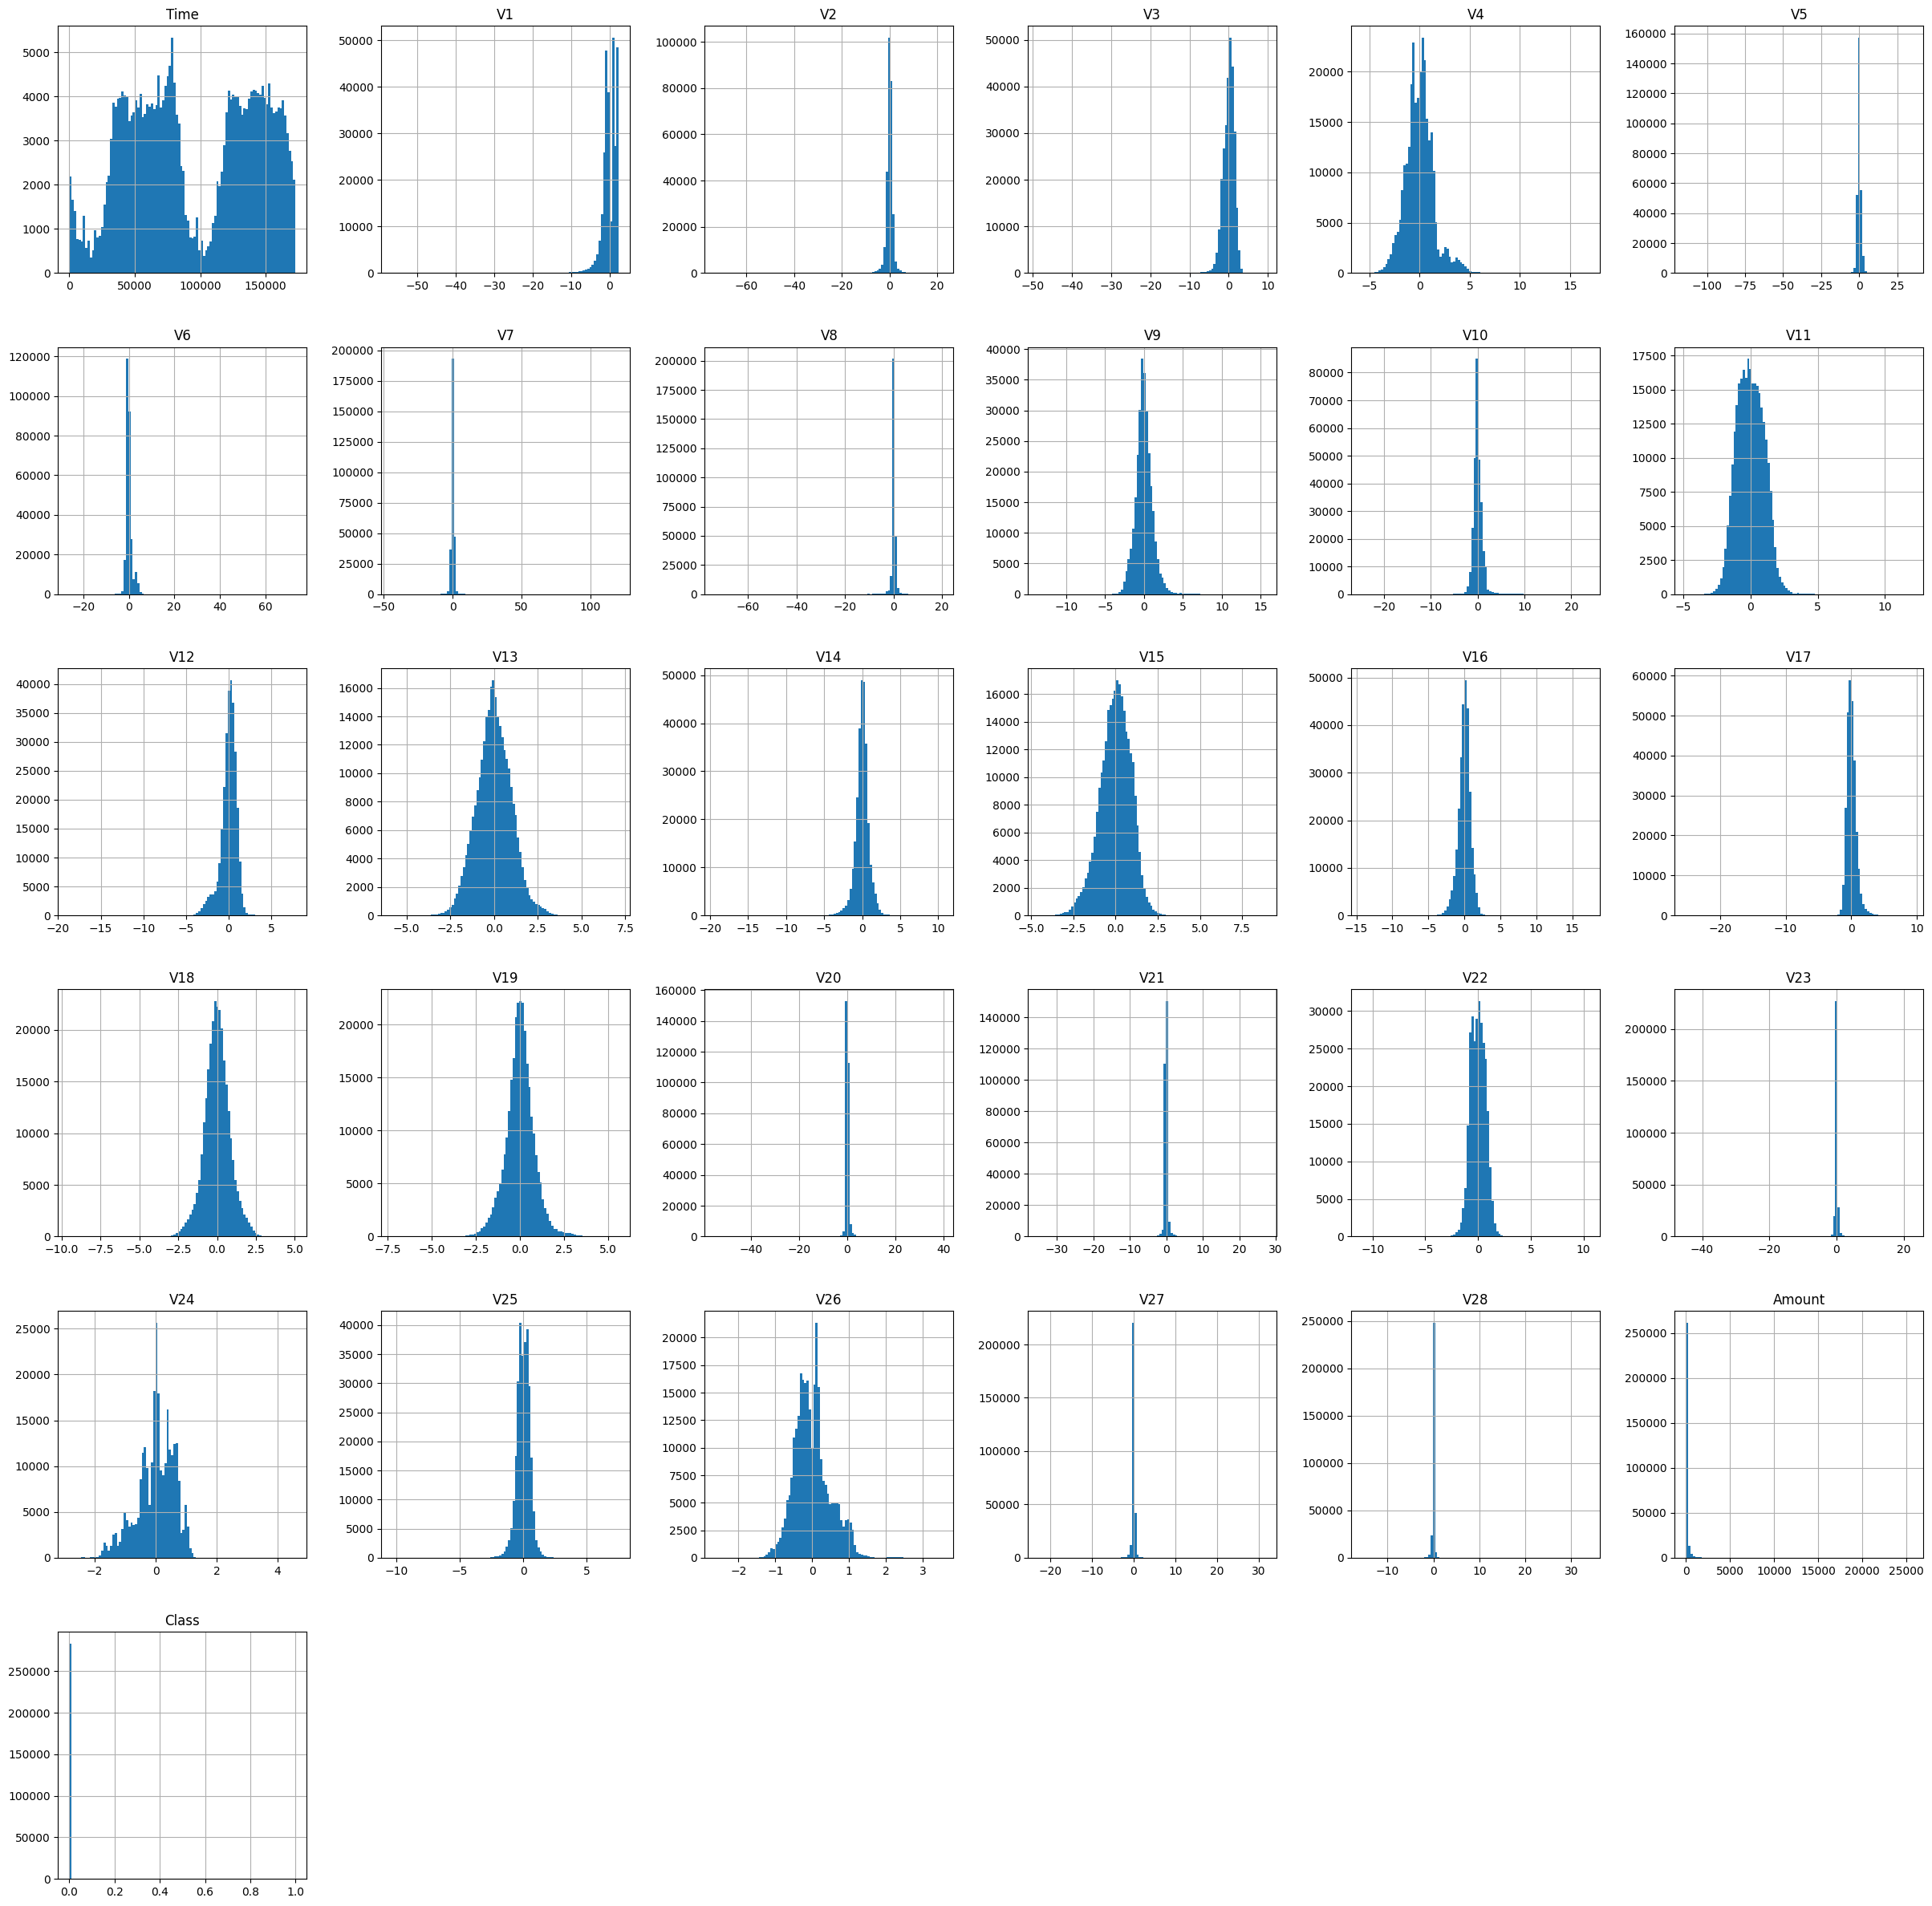

In [ ]:
# See the distribution of all features
df.hist(bins=100, figsize=(30,30))
plt.show()
# Interesting peaks and troughs in Time
# All (minus 1) of the PCA engineered features seem to be centered around 0 with similar ranges, close to normal distribution
# V1 seems to be the exception, have a skew to the left
# Amount appears to have a slight skew, with potential for outliers given the nature of the data

In [ ]:
# Describe data
df.describe()
# Amount has outliers (large max value)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,-0.001441,0.000202,-0.000715,0.000603,0.000252,0.001043,0.001162,0.000170,0.001515,-0.000264,0.000187,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,1.076407,1.018720,0.994674,0.995430,0.952215,0.914894,0.873696,0.842507,0.837378,0.813379,0.769984,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.683715,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,-0.535578,-0.761649,-0.406198,-0.647862,-0.425732,-0.581452,-0.466860,-0.483928,-0.498014,-0.456289,-0.211469,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,-0.093237,-0.032306,0.139072,-0.012927,0.050209,0.049299,0.067119,-0.065867,-0.002142,0.003367,-0.062353,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,0.453619,0.739579,0.616976,0.663178,0.492336,0.650104,0.523512,0.398972,0.501956,0.458508,0.133207,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742,17.315112,9.253526,5.041069,5.591971,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


In [ ]:
# As we can see from the above, time is not time of day
# Time refers to seconds elapsed since first transaction of the dataset
# Time in future data will all be greater than the max time of this dataset
# Time of day would be beneficial (fraud may occur more often at night)
# However, we can't calculate this since time zone isn't known (transactions with same time elapsed could be at different times)
# Therefore, we should drop time entirely
df.drop(columns=['Time'], inplace=True)

In [ ]:
# Split train and test data
X = df.drop(columns=['Class'])
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                   random_state=42,
                                   test_size=0.2,
                                   stratify=y)

In [ ]:
# Ensure roughly equal class distribution for y_train and y_test

In [ ]:
# Train class distribution
y_train.value_counts(normalize=True)

,proportion
Class,
0,0.998335
1,0.001665


In [ ]:
# Test class distribution
y_test.value_counts(normalize=True)

,proportion
Class,
0,0.998326
1,0.001674


In [ ]:
# Roughly equal class distribution for train and test data

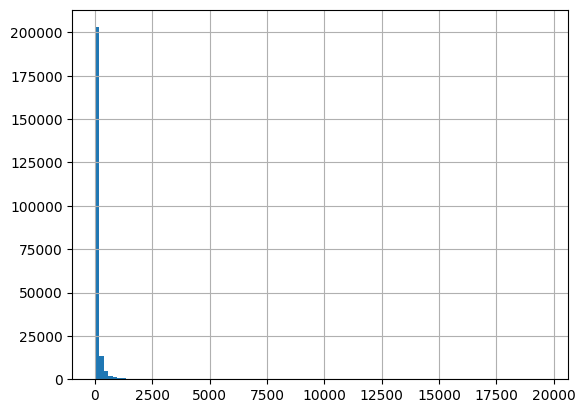

In [ ]:
# Let's confirm the skew that we saw in the Amount feature
X_train['Amount'].hist(bins=100)
plt.show()

In [ ]:
# In order to reduce this skew, we will apply log transformation to this column
# We will transform and scale this data in the test set as well to ensure consistency
X_train['Amount_log'] = np.log1p(X_train['Amount'])
X_test['Amount_log'] = np.log1p(X_test['Amount'])

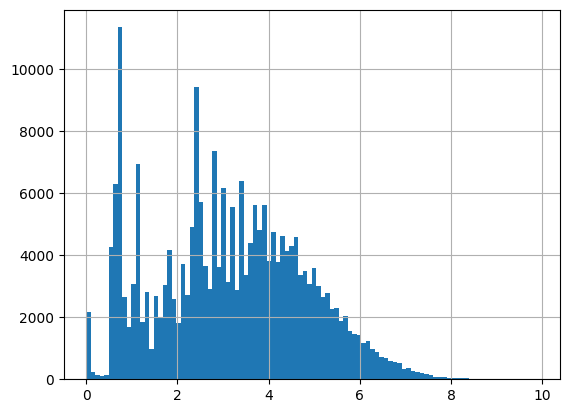

In [ ]:
# Check the distribution of log transformed amount
X_train['Amount_log'].hist(bins=100)
plt.show()

In [ ]:
# Now that we've transformed Amount, we should scale it to be similar to the rest of the data
# The PCA engineered data seems to all have a mean around 0, std. dev. between 0.3 and 2.0
# Because of that, plus the distribution being close to normal, standard scaler works

scaler = StandardScaler()
X_train['Amount_log_scaled'] = scaler.fit_transform(X_train[['Amount_log']])
X_test['Amount_log_scaled'] = scaler.transform(X_test[['Amount_log']])

In [ ]:
# Check updated description of scaled train data
X_train.describe()
# Mean of amount_log_scaled is around 0, std. dev. around 1

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Amount_log,Amount_log_scaled
count,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,2.269800e+05
mean,0.005027,-0.005549,0.002131,-0.002025,0.004941,-0.001961,0.001480,-0.000215,-0.002883,-0.002180,0.000080,0.000046,-0.000673,-0.001629,0.000893,0.001327,-0.000625,0.002273,0.000704,0.000649,0.001068,0.000073,-0.000230,0.000042,0.000247,0.000306,0.001682,0.000948,88.387124,3.156136,1.811574e-16
std,1.947293,1.649617,1.507270,1.416960,1.359643,1.323401,1.200181,1.169342,1.094055,1.073212,1.018662,0.992366,0.994018,0.954289,0.914289,0.873663,0.843116,0.837343,0.813639,0.759510,0.722252,0.724366,0.625700,0.605816,0.521633,0.481386,0.390579,0.325749,245.767046,1.656234,1.000002e+00
min,-56.407510,-72.715728,-33.680984,-5.683171,-32.092129,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.553697,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-23.646890,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000,-1.905614e+00
25%,-0.915886,-0.601108,-0.887261,-0.849272,-0.689146,-0.768760,-0.552497,-0.208633,-0.644309,-0.535903,-0.761505,-0.404977,-0.648616,-0.427256,-0.581114,-0.466734,-0.484141,-0.497771,-0.455316,-0.211549,-0.228123,-0.541639,-0.162429,-0.354804,-0.317685,-0.326576,-0.070526,-0.052626,5.690000,1.900614,-7.580600e-01
50%,0.018358,0.063820,0.178307,-0.021999,-0.052477,-0.275923,0.040832,0.022232,-0.052811,-0.093670,-0.031345,0.138053,-0.013073,0.048861,0.049168,0.068389,-0.065628,-0.001141,0.004873,-0.062147,-0.028727,0.007424,-0.011397,0.041119,0.016167,-0.051704,0.001499,0.011458,22.080000,3.138966,-1.036679e-02
75%,1.315404,0.801327,1.027460,0.741399,0.615362,0.397381,0.571905,0.325467,0.594205,0.454153,0.740219,0.616503,0.661487,0.491511,0.649065,0.523625,0.396778,0.502451,0.459755,0.133575,0.186916,0.528913,0.148110,0.440116,0.351206,0.240059,0.091401,0.078757,77.850000,4.367547,7.314265e-01
max,2.454930,22.057729,9.382558,16.875344,34.801666,21.393069,34.303177,20.007208,15.594995,23.745136,12.018913,7.848392,4.569009,10.526766,5.825654,7.059132,9.253526,5.041069,5.572113,39.420904,27.202839,10.503090,22.528412,4.016342,7.519589,3.517346,12.152401,33.847808,19656.530000,9.886216,4.063491e+00


In [ ]:
# Now that we aren't training or testing on original or log amount, delete columns
X_train.drop(columns=['Amount'], inplace=True)
X_train.drop(columns=['Amount_log'], inplace=True)
X_test.drop(columns=['Amount'], inplace=True)
X_test.drop(columns=['Amount_log'], inplace=True)

In [ ]:
# Create joblib files for the data
joblib.dump(X_train, f'{base_path}X_train.joblib')
joblib.dump(X_test, f'{base_path}X_test.joblib')
joblib.dump(y_train, f'{base_path}y_train.joblib')
joblib.dump(y_test, f'{base_path}y_test.joblib')

['/content/drive/MyDrive/Portfolio projects/Credit Card Fraud Detection/joblib files/y_test.joblib']

Additionally, we could balance the data by oversampling the minority or undersampling the majority and see if model performance improves. We can also consider scaling the PCA features as well. For now, I will not scale the already engineered PCA features and we won't balance the data. I will do that in Part 2.

# Performance Metrics

Type I Error: False positive (classifying a legitimate transaction as fraud)
- Transaction does not go through immediately
- Customer can call customer service to verify identity and allow transaction to go through
- **Downside: Minor inconvenience, resolved in minutes, no money lost**

Type II Error: False negative (classifying a fraud transaction as legitimate)
- Transaction goes through
- Customer will likely notice transaction after the fact and report it as fraud
- Credit card no longer valid, replacement needs to be sent to customer
- Merchant is considered liable and has to provide customer a full refund
- **Downside: Major inconvenience, takes days-weeks to resolve, merchant loses money despite providing product/service**

...

- Type II Errors have far more consequences (minimizing false negatives is a priority)
- Therefore, we want to **recall** as many fraud instances we can (fraud is the minority class and makes up for 0.172% of all instances)
- We still want to maintain a high level of **precision** to keep customers happy and reduce the demand for customer support

...

 **Based on the nature of our dataset, recall and precision will be the prioritized metrics (more specifically, we will see how far we can maximize recall without detroying our model precision). Additionally, we will look at the other metrics mentioned below**
 - AUC-PR and F1-Score balance precision and recall (AUC-ROC tends to be overly optimistic in heavily imbalanced datasets)
 - F2-Score is similar to F1-Score, but prioritizes recall over precision (so we will prioritize F2-Score over F1-Score)
 - Using these metrics along with looking at the PR-Curve itself, we can compare the performances of each model in a holistic manner and find optimal thresholds for each model

**Note: A more novel and business-oriented approach to measuring performance would be to come up with an impact score/scoring function for false positives and negatives. These scores would quantify severity of each error and allow for comparison (e.g., if a fraudulent transaction of 50 euros is determined by the bank to be equivalent to 150 valid transactions getting denied, they would have the same score). The model with the lowest summed error score would be the highest performing one.**

In [ ]:
# Other metrics already imported
# AUC-PR
def auc_pr_score(y_true, y_pred_proba):
  precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
  return auc(recall, precision)

In [ ]:
# Create dictionaries for model scores and PR curve
model_pr_curves_pt1_path = Path(f"{base_path}model_pr_curves_pt1.joblib")
model_scores_pt1_path = Path(f"{base_path}model_scores_pt1.joblib")

if model_pr_curves_pt1_path.exists():
    model_pr_curves_pt1 = joblib.load(model_pr_curves_pt1_path)  # Load the existing dictionary
else:
    model_pr_curves_pt1 = {}

if model_scores_pt1_path.exists():
    model_scores_pt1 = joblib.load(model_scores_pt1_path)  # Load the existing dictionary
else:
    model_scores_pt1 = {}

# Modeling:

- We will be using the following algorithms for this dataset:
 - Logistic Regression
 - Decision Tree
 - KNN
 - Random Forest
 - XGBoost
 - LightGBM

In [ ]:
# Create a function to fit and evaluate different models, store values for PR plotting

# Helper function to evaluate model after fitting
def evaluate(name, y_test, y_pred, y_pred_proba, y_train, time_elapsed):
  minutes, seconds = divmod(time_elapsed, 60)
  model_scores_pt1[name] = {
    "Accuracy Score": f"{accuracy_score(y_test, y_pred):.3f}",
    "Precision Score": f"{precision_score(y_test, y_pred):.3f}",
    "Recall Score": f"{recall_score(y_test, y_pred):.3f}",
    "F1 Score": f"{f1_score(y_test, y_pred):.3f}",
    "F0.5 Score": f"{fbeta_score(y_test, y_pred, beta=0.5):.3f}",
    "F2 Score": f"{fbeta_score(y_test, y_pred, beta=2):.3f}",
    "AUC-PR": f"{auc_pr_score(y_test, y_pred_proba):.3f}",
    "Time Elapsed": f"{minutes:.0f} minutes {round(seconds)} seconds"
  }
  joblib.dump(model_scores_pt1, model_scores_pt1_path)

# Main function
def fit_evaluate(name, model, X_train, y_train):

  # Time the model fitting/prediction
  start_time = time.time()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_pred_proba = model.predict_proba(X_test)[:,1]
  precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
  time_elapsed = time.time() - start_time

  # Evaluate model performance with helper method
  evaluate(name, y_test, y_pred, y_pred_proba, y_train, time_elapsed)

  # Store PR curve coordinates
  model_pr_curves_pt1[name] = {
        "precision": precision,
        "recall": recall,
        "thresholds": thresholds
    }

# Print metrics
def print_metrics(name):
  print(name)
  for key, value in model_scores_pt1[name].items():
    print(f"{key}: {value}")

In [ ]:
if 'Logistic Regression' not in model_scores_pt1:
    log_reg = LogisticRegression(random_state=42)
    fit_evaluate('Logistic Regression', log_reg, X_train, y_train)

print_metrics('Logistic Regression')

Logistic Regression
Accuracy Score: 0.999
Precision Score: 0.864
Recall Score: 0.600
F1 Score: 0.708
F0.5 Score: 0.794
F2 Score: 0.639
AUC-PR: 0.700
Time Elapsed: 0 minutes 1 seconds


In [ ]:
if 'Decision Tree' not in model_scores_pt1:
  decision_tree = DecisionTreeClassifier(random_state=42)
  fit_evaluate('Decision Tree', decision_tree, X_train, y_train)

print_metrics('Decision Tree')

Decision Tree
Accuracy Score: 0.999
Precision Score: 0.714
Recall Score: 0.684
F1 Score: 0.699
F0.5 Score: 0.708
F2 Score: 0.690
AUC-PR: 0.700
Time Elapsed: 0 minutes 28 seconds


In [ ]:
if 'KNN' not in model_scores_pt1:
    knn = KNeighborsClassifier(n_neighbors=5)
    fit_evaluate('KNN', knn, X_train, y_train)

print_metrics('KNN')

KNN
Accuracy Score: 0.999
Precision Score: 0.957
Recall Score: 0.705
F1 Score: 0.812
F0.5 Score: 0.893
F2 Score: 0.744
AUC-PR: 0.847
Time Elapsed: 3 minutes 31 seconds


In [ ]:
if 'Random Forest' not in model_scores_pt1:
  rf = RandomForestClassifier(random_state=42)
  fit_evaluate('Random Forest', rf, X_train, y_train)

print_metrics('Random Forest')

Random Forest
Accuracy Score: 1.000
Precision Score: 0.972
Recall Score: 0.737
F1 Score: 0.838
F0.5 Score: 0.914
F2 Score: 0.774
AUC-PR: 0.802
Time Elapsed: 5 minutes 24 seconds


In [ ]:
if 'XGBoost' not in model_scores_pt1:
  xgb = XGBClassifier(random_state=42)
  fit_evaluate('XGBoost', xgb, X_train, y_train)

print_metrics('XGBoost')

XGBoost
Accuracy Score: 1.000
Precision Score: 0.973
Recall Score: 0.747
F1 Score: 0.845
F0.5 Score: 0.917
F2 Score: 0.784
AUC-PR: 0.827
Time Elapsed: 0 minutes 8 seconds


In [ ]:
if 'LightGBM' not in model_scores_pt1:
  lgbm = LGBMClassifier(random_state=42)
  fit_evaluate('LightGBM', lgbm, X_train, y_train)

print_metrics('LightGBM')

LightGBM
Accuracy Score: 0.997
Precision Score: 0.221
Recall Score: 0.358
F1 Score: 0.273
F0.5 Score: 0.239
F2 Score: 0.318
AUC-PR: 0.231
Time Elapsed: 0 minutes 5 seconds


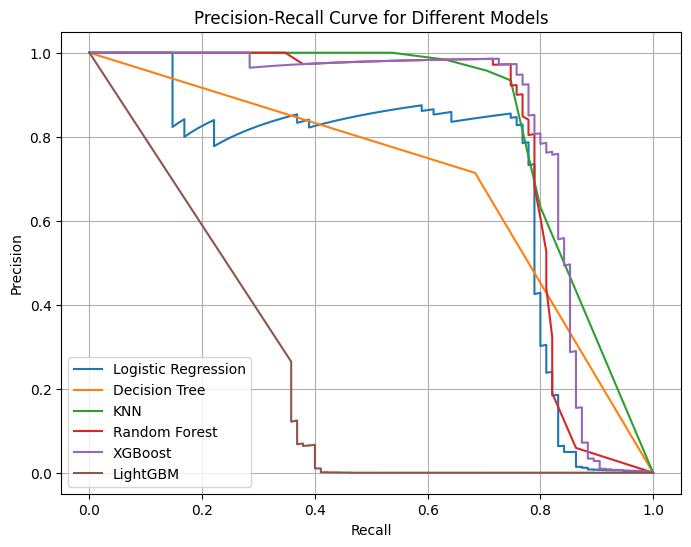

In [ ]:
# Load the PR dictionary
model_pr_curves_pt1 = joblib.load(model_pr_curves_pt1_path)

def plot_pr_curves(model_pr_curves_pt1):
  # Set up the plot
  plt.figure(figsize=(8, 6))

  # Plot PR curves for each model stored in model_pr_curves_pt1
  for model_name, metrics in model_pr_curves_pt1.items():
      precision = metrics['precision']
      recall = metrics['recall']

      plt.plot(recall, precision, label=f'{model_name}')

  # Customize the plot
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve for Different Models')
  plt.legend(loc='best')
  plt.grid(True)

  # Show the plot
  plt.show()

plot_pr_curves(model_pr_curves_pt1)

# Evaluation

- The top performing algorithms were KNN, Random Forest, and XGBoost
- KNN had the highest AUC because of it's high (relatively) performance across different thresholds, but performed slightly worse than Random Forest and XGBoost at what appear to be viable thresholds (the elbows on the PR-Curve with both precision and recall hovering around 80% for the other models)
- However, KNN was able to have a high (90%+) recall score at certain thresholds while not taking as big of a hit to precision as the other models
- XGBoost has the second highest AUC-PR score, along with the highest F-Scores (F1, F2, and F0.5), recall rate, precision rate
- KNN and XGBoost appear to be the two winners in Part 1 (XGBoost if maintaining precision high is very important, KNN if precision can take a bigger hit (arount 47%) if it means improving recall significantly)
- As mentioned earlier, a way to quantify the negative impact of each error type would be helpful in understanding how much we should be willing to sacrifice precision if it means improving our recall rate. I personally believe that KNN is the strongest of the models in this case due to its relatively higher precision when prioritizing recall.